# 230518_causal_tracing_weights_v2
a wide range of fine-tuned models

# Import libraries

In [7]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer
from datasets import load_dataset
from tqdm import tqdm
import json
import torch
import argparse
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
from os import listdir
import json
import math

/rds/general/user/jj1122/home/anaconda3/envs/test1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
sns.set_style("darkgrid")

In [2]:
# dataset_nm = "Health_and_fitness"
# dataset_path = f"../m2d2/dataset/{dataset_nm}/train.txt"
cache_dir="/rds/general/user/jj1122/ephemeral/.cache/huggingface"
data_dir = "../m2d2/dataset"

In [3]:
def get_model_path(model_id):
    model_path_format = "/rds/general/user/jj1122/home/projects/m2d2/dataset/{model_id}/models"
    ckpt_path_format = "/checkpoint-{ckpt}"

    if model_id == "gpt2":
        model_path = "gpt2"
#         ckpt = "zs"
    else:
        model_path = model_path_format.format(model_id=model_id)
        l_dir = listdir(model_path)

        if all([len(x.split(".")) == 1 for x in l_dir]):
            ckpt = max([int(x.split("-")[1]) for x in l_dir])
            model_path += ckpt_path_format.format(ckpt=ckpt)
#         else:
#             ckpt = "final"
    return model_path

In [4]:
list_models = [
    "cs_l1",
    "nlin_l1",
    "Health_and_fitness",
    "Natural_and_physical_sciences",
    "Religion_and_belief_systems",
    "Culture_and_the_arts",
    "General_referece",
    "econ_l1",
    "History_and_events",
    "Mathematics_and_logic",
    "q-fin_l1",
    "Philosophy_and_thinking",
    "Society_and_social_sciences"
]

In [10]:
device_id = 'cpu'
n_layers = 12
list_modules = ['attn', 'mlp']
trace_module_id = "transformer.h.{l}.{m}"

In [11]:
list_trace_module_ids = []

for l in range(n_layers):
    for m in list_modules:
        list_trace_module_ids.append(trace_module_id.format(l=l, m=m))

print(list_trace_module_ids[:3])

['transformer.h.0.attn', 'transformer.h.0.mlp', 'transformer.h.1.attn']


# Model

## load **13** finetuned models with EarlyStopper

In [217]:
config_models = {model_id: {} for model_id in list_models}
for model_id in list_models:
    config_models[model_id]["model_path"] = get_model_path(model_id)
    json_path = config_models[model_id]["model_path"] + "/trainer_state.json"
    with open(json_path, "r") as json_file:
        trainer_state = json.load(json_file)
        config_models[model_id]["ppl"] = math.exp(trainer_state["best_metric"])
        config_models[model_id]["steps"] = int(trainer_state["best_model_checkpoint"].split("/")[-1].split("-")[-1])
        config_models[model_id]["eps"] = float(trainer_state["epoch"])

In [12]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=cache_dir).to(device_id)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", cache_dir=cache_dir)

## Get difference in weights
```diff = np.mean(np.abs(model_a.weights - model_b.weights))```

In [446]:
for k, v in base_model.named_parameters():
    print(k)
#     if k  == "transformer.h.0.attn.c_attn.bias":
#         attn_b = v
#     if k  == "transformer.h.0.attn.c_attn.weight":
#         attn_w = v
#     if "ln_1" in k and "weight" in k :
# #         print(k)
#         ln_1_w = v

#     if "ln_1" in k and "bias" in k :
# #         print(k)
#         ln_1_b = v

#     if "head" in k :
# #         print(k)
#         head = v


transformer.wte.weight
transformer.wpe.weight
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_1.bias
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_attn.bias
transformer.h.1.attn.c_proj.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.ln_2.weight
transformer.h.1.ln_2.bias
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_fc.bias
transformer.h.1.mlp.c_proj.weight
transformer.h.1.mlp.c_proj.bias
transformer.h.2.ln_1.weight
transformer.h.2.ln_1.bias
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_attn.bias
transformer.h.2.attn.c_proj.weight
transformer.h.2.attn.c_proj.bias
transformer.h.2.ln_2

In [426]:
tuned_model = GPT2LMHeadModel.from_pretrained(config_models["cs_l1"]["model_path"]).to(device_id)

In [447]:
for x in tuned_model.lm_head.named_parameters():
    print(x)

('weight', Parameter containing:
tensor([[-0.0569, -0.0311,  0.0599,  ..., -0.0738,  0.0517, -0.0129],
        [ 0.0120, -0.0348,  0.0342,  ...,  0.0318, -0.0172,  0.0192],
        [-0.1029, -0.0119,  0.0915,  ...,  0.0414, -0.0894, -0.0864],
        ...,
        [-0.0327, -0.0641,  0.0242,  ...,  0.0773,  0.0409, -0.0510],
        [ 0.1016,  0.0116,  0.0276,  ..., -0.0607,  0.0448, -0.0123],
        [ 0.0203, -0.0101,  0.0494,  ..., -0.0105,  0.0788,  0.0611]],
       requires_grad=True))


In [466]:
def get_diff_from_tensors(a, b):
    return torch.abs(a - b).mean().item()

dict_diff_weights = {}
dict_module_params = {}
for k, v_dict in config_models.items():
#     print(k)
#     dict_diff_weights[k +"."+tuned_tup[0]]
    tuned_model = GPT2LMHeadModel.from_pretrained(v_dict["model_path"]).to(device_id)
    for tuned_tup, base_tup in zip(list(tuned_model.named_parameters()), list(base_model.named_parameters())):

        dict_module_params[base_tup[0]]= base_tup[1].numel()
        
        if "c_attn" in tuned_tup[0]:
            dim_size = len(base_tup[1].shape) - 1
            emb_size = base_tup[1].shape[dim_size] // 3
            
            base_q, base_k, base_v = torch.split(base_tup[1], [emb_size]*3, dim=dim_size)
            tuned_q, tuned_k, tuned_v = torch.split(tuned_tup[1], [emb_size]*3, dim=dim_size)

            assert base_q.shape == tuned_q.shape
            assert base_k.shape == tuned_k.shape
            assert base_v.shape == tuned_v.shape
            
            dict_diff_weights[k +"."+ tuned_tup[0].replace("c_attn", "c_attn_Q")] = get_diff_from_tensors(tuned_q, base_q)
            dict_diff_weights[k +"."+ tuned_tup[0].replace("c_attn", "c_attn_K")] = get_diff_from_tensors(tuned_k, base_k)
            dict_diff_weights[k +"."+ tuned_tup[0].replace("c_attn", "c_attn_V")] = get_diff_from_tensors(tuned_v, base_v)
        else:
            dict_diff_weights[k +"."+tuned_tup[0]] = get_diff_from_tensors(tuned_tup[1], base_tup[1])

#     for tuned_tup, base_tup in zip(list(tuned_model.lm_head.named_parameters()), list(base_model.lm_head.named_parameters())):
#         dict_module_params["transformer.ln_head.weight"]= base_tup[1].numel()
#         dict_diff_weights[k +"."+"transformer.ln_head.weight"] = get_diff_from_tensors(tuned_tup[1], base_tup[1])        
        
    del tuned_model

In [467]:
df_avg_diff_weights = pd.DataFrame.from_dict(dict_diff_weights, orient='index')

df_avg_diff_weights = df_avg_diff_weights.reset_index()
df_avg_diff_weights.columns = ["code", "diff"]

df_avg_diff_weights["code_split"] = df_avg_diff_weights["code"].str.split(".")
df_avg_diff_weights["dataset"] = df_avg_diff_weights["code_split"].apply(lambda l: l[0])

df_avg_diff_weights["layer"] = df_avg_diff_weights["code_split"].apply(lambda l: int(l[3]) if l[2] == "h" else -1)


df_avg_diff_weights["module"] = df_avg_diff_weights["code_split"].apply(lambda l: l[4] if l[2] == "h" else l[2])
df_avg_diff_weights["sub_module"] = df_avg_diff_weights["module"]
df_avg_diff_weights.loc[df_avg_diff_weights["module"].isin(["attn", "mlp"]), "sub_module"] \
    += df_avg_diff_weights["code_split"].loc[df_avg_diff_weights["module"].isin(["attn", "mlp"])].apply(lambda l: l[5])

df_avg_diff_weights.loc[df_avg_diff_weights["sub_module"] == "ln_f", "layer"] = 99

# df_avg_diff_weights['final_module'] = \
#     df_avg_diff_weights[["layer", "module", "sub_module"]]\
#         .apply(lambda row: "-".join([str(row["layer"]), row["module"], row["sub_module"]]), axis=1)

df_avg_diff_weights["w_or_b"] = df_avg_diff_weights["code_split"].apply(lambda l: l[-1])

for dataset, d in config_models.items():
    for k, v in d.items():
        if k != "model_path":
            df_avg_diff_weights.loc[df_avg_diff_weights.dataset == dataset, k] = v

del df_avg_diff_weights["code"], df_avg_diff_weights["code_split"]

only_transformer_layers = ~(df_avg_diff_weights.layer.isin([-1, 99]))


### boxplot for the mean weight- and bias-differences by layers
##### Due to the different distributions, There exist too many **outliers**
##### Original weight-differences could cause confusion that the differences from fine-tuning or just running time

<Axes: xlabel='layer', ylabel='diff'>

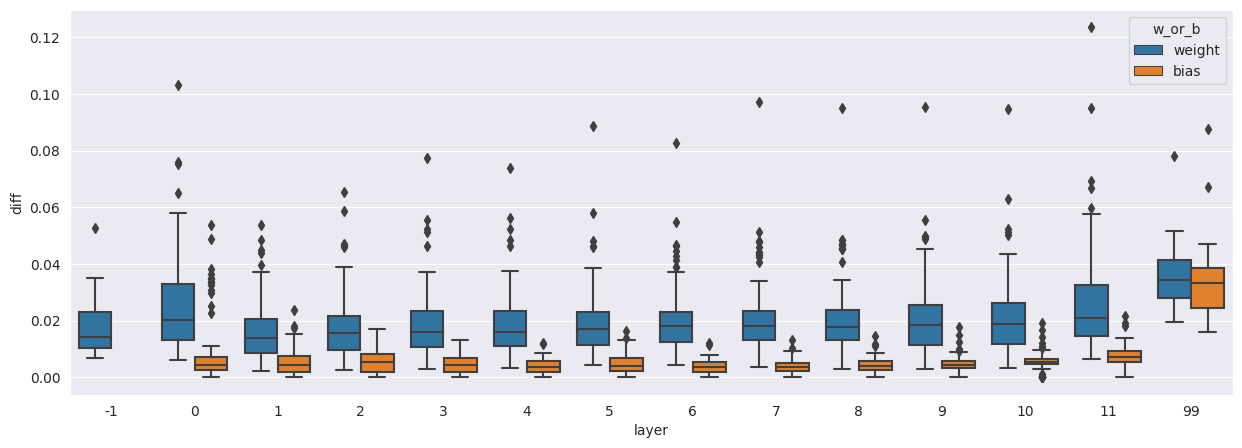

In [476]:
plt.rcParams["figure.figsize"] = (15,5)

sns.boxplot(
    df_avg_diff_weights,
    x='layer',  y='diff', hue='w_or_b'
#     , errorbar='se'
)

In [477]:
# df_temp_agg = df_avg_diff_weights.groupby(["layer", "w_or_b"])[['diff']]\
#     .agg({"diff": ["mean", "median"]})

# df_temp_agg = df_temp_agg.reset_index()
# df_temp_agg = df_temp_agg.melt(value_vars=["mean", "median"], ignore_index=False)
# plt.rcParams["figure.figsize"] = (5,5)
# g = sns.relplot(df_temp_agg.loc[df_temp_agg.w_or_b == 'weight'], x='mean', y='median', col='w_or_b')
# g.set(ylim=(0, 0.035), xlim=(0, 0.035))
# # , sizes=(0.35, 0.35)

### Corrleation between the difference in weights and training time from different datasets


In [478]:
df_avg_diff_weights.groupby(['dataset', 'eps', 'steps'])[['diff']].mean().reset_index().corr()

/var/tmp/pbs.7644459.pbs/ipykernel_485139/4288699062.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_avg_diff_weights.groupby(['dataset', 'eps', 'steps'])[['diff']].mean().reset_index().corr()


,eps,steps,diff
eps,1.000000,-0.484577,-0.441738
steps,-0.484577,1.000000,0.997564
diff,-0.441738,0.997564,1.000000


### Scaling the difference of weights
For each dataset, ```new_diff = original_diff  / n_steps  * 10**6```

In [479]:
df_avg_diff_weights['diff_v2'] = df_avg_diff_weights['diff'] / df_avg_diff_weights['steps'] * 10**6

### boxplot for the scaled and mean weight- and bias-differences by layers


<Axes: xlabel='layer', ylabel='diff_v2'>

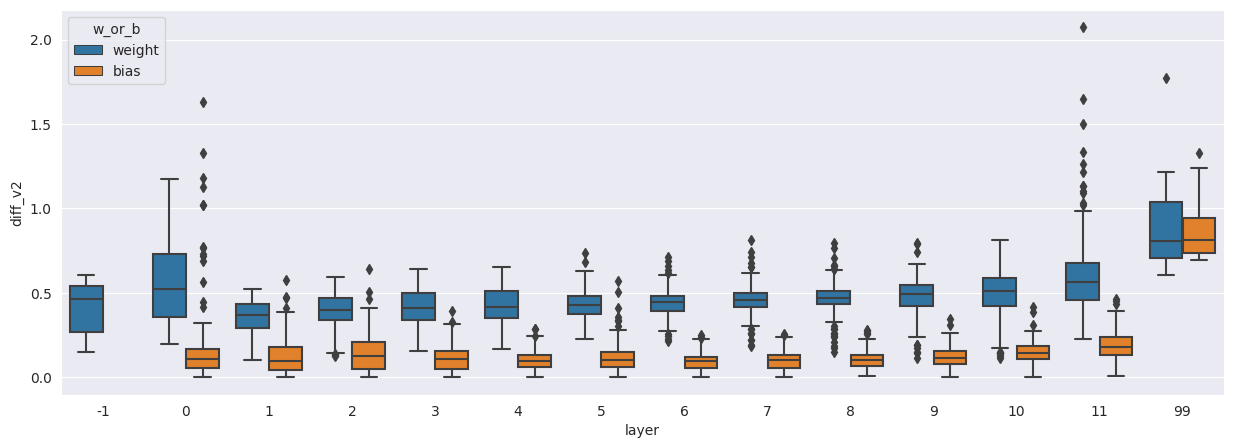

In [480]:
plt.rcParams["figure.figsize"] = (15,5)

sns.boxplot(
    df_avg_diff_weights,
    x='layer',  y='diff_v2', hue='w_or_b'
#     , errorbar='se'
)

### the number of parameters for each sub_module

In [481]:
df_module_params = pd.DataFrame.from_dict(dict_module_params, orient='index')
df_module_params = df_module_params.reset_index()
df_module_params.columns = ["code", "n_params"]


In [482]:
df_module_params["code_split"] = df_module_params["code"].str.split(".")
df_module_params["layer"] = df_module_params["code_split"].apply(lambda l: int(l[2]) if l[1] == "h" else -1)
df_module_params["module"] = df_module_params["code_split"].apply(lambda l: l[3] if l[1] == "h" else l[1])
df_module_params["sub_module"] = df_module_params["module"]
df_module_params.loc[df_module_params["module"].isin(["attn", "mlp"]), "sub_module"] \
    += df_module_params["code_split"].loc[df_module_params["module"].isin(["attn", "mlp"])].apply(lambda l: l[4])
df_module_params.loc[df_module_params["sub_module"] == "ln_f", "layer"] = 99
df_module_params["w_or_b"] = df_module_params["code_split"].apply(lambda l: l[-1])


In [483]:
df_module_params[['sub_module', 'w_or_b', 'n_params']].drop_duplicates()

,sub_module,w_or_b,n_params
0,wte,weight,38597376
1,wpe,weight,786432
2,ln_1,weight,768
3,ln_1,bias,768
4,attnc_attn,weight,1769472
5,attnc_attn,bias,2304
6,attnc_proj,weight,589824
7,attnc_proj,bias,768
8,ln_2,weight,768
9,ln_2,bias,768


# Result

### Avg diff group by layer and moudle

In [355]:
# df_avg_diff_weights.loc[only_transformer_layers]\
#     .groupby(["layer", "module"])[['diff_v2']].describe()[[('diff_v2', 'mean'), ('diff_v2', 'std')]]\
#     .sort_values(by=[('diff_v2', 'mean'), ('diff_v2', 'std')]).unstack(-2)

In [356]:
# df_avg_diff_weights.loc[~only_transformer_layers]\
#     .groupby(["module"])[['diff_v2']].describe()[[('diff_v2', 'mean'), ('diff_v2', 'std')]]\
#     .sort_values(by=[('diff_v2', 'mean'), ('diff_v2', 'std')])

<Axes: xlabel='layer', ylabel='diff_v2'>

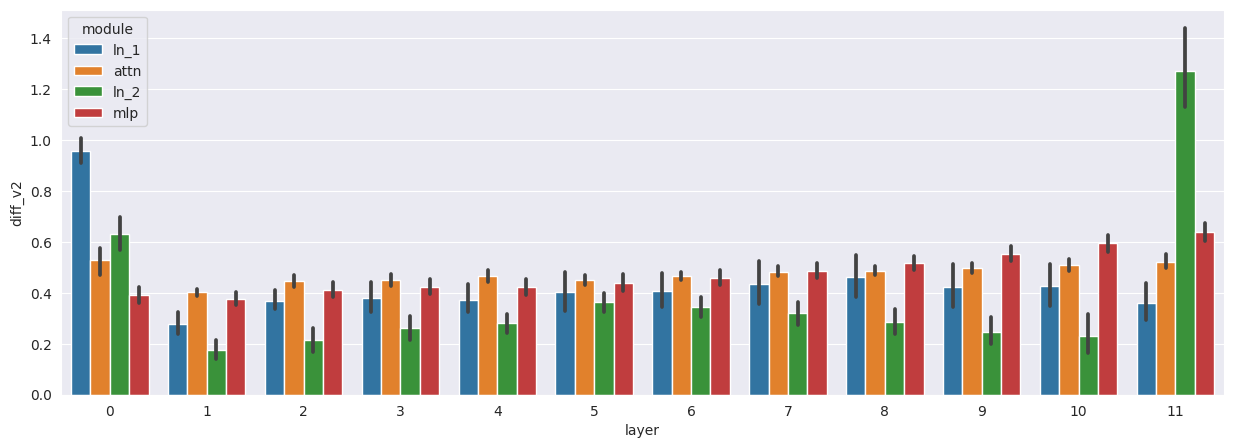

In [484]:
plt.rcParams["figure.figsize"] = (15,5)

sns.barplot(
    df_avg_diff_weights.loc[
        (df_avg_diff_weights.w_or_b == 'weight')
        & ~(df_avg_diff_weights.layer.isin([ -1, 99]))  
#         & (df_avg_diff_weights.dataset == 'cs_l1')
    ], 
    x='layer', hue='module', y='diff_v2'
#     , errorbar='se'
)

<Axes: xlabel='layer', ylabel='diff_v2'>

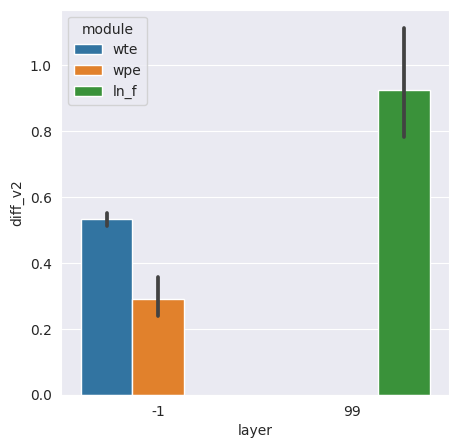

In [485]:
plt.rcParams["figure.figsize"] = (5,5)

sns.barplot(
    df_avg_diff_weights.loc[
        (df_avg_diff_weights.layer.isin([ -1, 99])) 
        & (df_avg_diff_weights.w_or_b == 'weight')
#         & (df_avg_diff_weights.dataset == 'cs_l1')
    ], 
    x='layer', hue='module', y='diff_v2', estimator="mean"
#     , errorbar='se'
)

### Avg diff group by layer and sub_module

<Axes: xlabel='layer', ylabel='diff'>

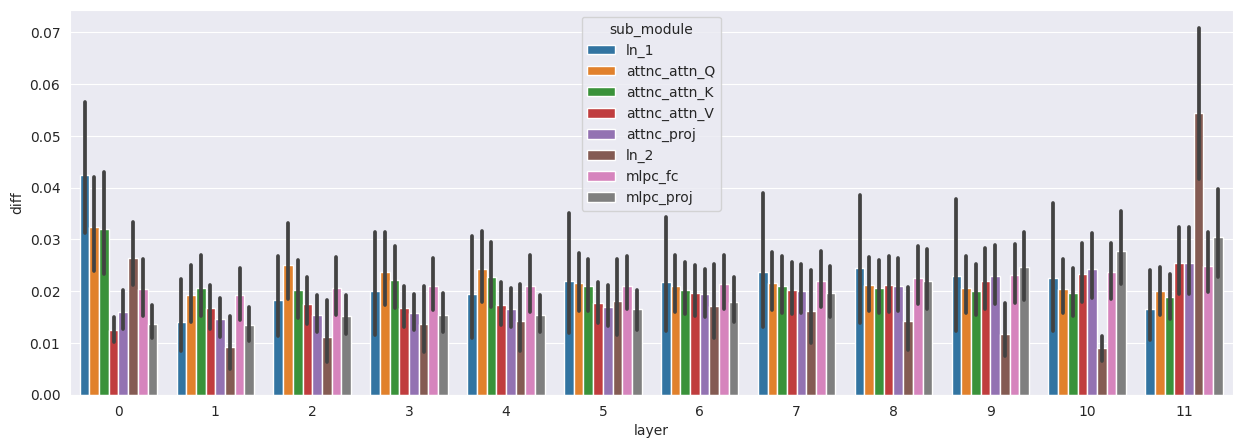

In [486]:
plt.rcParams["figure.figsize"] = (15,5)

sns.barplot(df_avg_diff_weights.loc[only_transformer_layers & (df_avg_diff_weights.w_or_b == 'weight')], x='layer', hue='sub_module', y='diff')

### Top 10 of avg diff group by layer and (module or sub_module)

In [508]:
df_avg_diff_weights.groupby(["module", "layer"])[["diff_v2", "diff"]].mean()\
    .sort_values("diff_v2", ascending=False).head(10)

,,diff_v2,diff
module,layer,,
ln_f,99,0.900961,0.037451
ln_2,11,0.777260,0.032868
ln_1,0,0.578404,0.024782
wte,-1,0.532866,0.023607
attn,0,0.411935,0.017344
mlp,11,0.411391,0.017304
ln_2,0,0.379362,0.015608
mlp,10,0.371032,0.015598
ln_1,5,0.358434,0.016826


In [509]:
df_avg_diff_weights.groupby(["sub_module", "layer"])[["diff_v2"]].mean()\
    .sort_values("diff_v2", ascending=False).head(10)

diff_v2
sub_module   layer          
ln_f          99    0.900961
attnc_attn_Q  0     0.819611
ln_2          11    0.777260
ln_1          0     0.578404
wte          -1     0.532866
mlpc_proj     11    0.439580
attnc_attn_Q  2     0.405000
              1     0.387060
attnc_attn_V  11    0.384592
mlpc_fc       11    0.383201